In [1]:
import pandas as pd
df = pd.read_csv('labels_paper.csv', lineterminator='\n')
df.head()

,results,message
0,feature,Use github's new relative path format.
1,corrective,Fix conditional variance of LS estimate.In 18....
2,merge,Merge pull request #8 from cortex/masterShared...
3,none,Integrate Mathieu Bryen's pull request.
4,merge,Merge branch 'master' of github.com:mavam/stat...


In [2]:
df = df[pd.notnull(df['message'])]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599870 entries, 0 to 601076
Data columns (total 2 columns):
results    599870 non-null object
message    599870 non-null object
dtypes: object(2)
memory usage: 13.7+ MB


In [4]:
#col = ['Product', 'Consumer complaint narrative']
#df = df[col]

In [5]:
df.columns

Index(['results', 'message'], dtype='object')

In [6]:
#df.columns = ['Product', 'Consumer_complaint_narrative']

In [7]:
df['category_id'] = df['results'].factorize()[0]
from io import StringIO
category_id_df = df[['results', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'results']].values)

In [8]:
df.head()

,results,message,category_id
0,feature,Use github's new relative path format.,0
1,corrective,Fix conditional variance of LS estimate.In 18....,1
2,merge,Merge pull request #8 from cortex/masterShared...,2
3,none,Integrate Mathieu Bryen's pull request.,3
4,merge,Merge branch 'master' of github.com:mavam/stat...,2


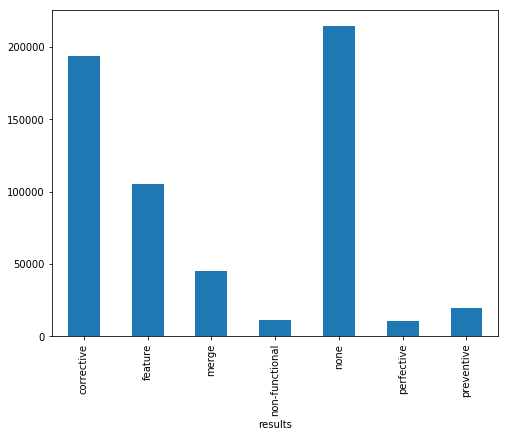

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('results').message.count().plot.bar(ylim=0)
plt.show()

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.2, max_df=0.7, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.message).toarray()
labels = df.category_id
features.shape

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [55]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for results, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(results))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'corrective':
  . Most correlated unigrams:
       . svn
       . fix
  . Most correlated bigrams:
       . 
# 'feature':
  . Most correlated unigrams:
       . merge
       . fix
  . Most correlated bigrams:
       . 
# 'merge':
  . Most correlated unigrams:
       . com
       . merge
  . Most correlated bigrams:
       . 
# 'non-functional':
  . Most correlated unigrams:
       . merge
       . fix
  . Most correlated bigrams:
       . 
# 'none':
  . Most correlated unigrams:
       . merge
       . fix
  . Most correlated bigrams:
       . 
# 'perfective':
  . Most correlated unigrams:
       . merge
       . fix
  . Most correlated bigrams:
       . 
# 'preventive':
  . Most correlated unigrams:
       . merge
       . fix
  . Most correlated bigrams:
       . 


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['message'], df['results'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [27]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['corrective']


In [28]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['corrective']


In [29]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

KeyError: 'Consumer_complaint_narrative'

In [ ]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/geanderson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/geanderson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/geanderson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/geanderson/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/geanderson/miniconda3/lib/python3.7/site-package

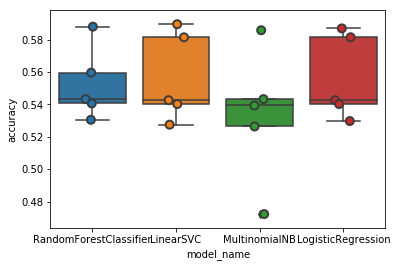

In [58]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [59]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.556187
LogisticRegression        0.556119
MultinomialNB             0.533353
RandomForestClassifier    0.552329
Name: accuracy, dtype: float64

In [60]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

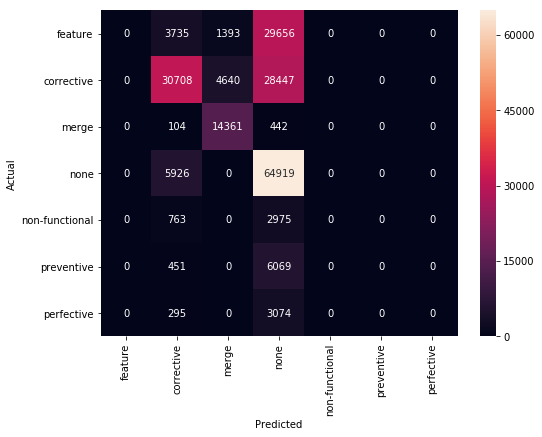

In [61]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.results.values, yticklabels=category_id_df.results.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [39]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'feature' predicted as 'corrective' : 3735 examples.


KeyError: "None of [Index(['Product', 'Consumer_complaint_narrative'], dtype='object')] are in the [columns]"

In [40]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [24]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . account
  . Top bigrams:
       . debit card
       . overdraft fees
# 'Consumer Loan':
  . Top unigrams:
       . vehicle
       . car
  . Top bigrams:
       . personal loan
       . history xxxx
# 'Credit card':
  . Top unigrams:
       . card
       . discover
  . Top bigrams:
       . credit card
       . discover card
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . transunion
  . Top bigrams:
       . xxxx account
       . trans union
# 'Debt collection':
  . Top unigrams:
       . debt
       . collection
  . Top bigrams:
       . account credit
       . time provided
# 'Money transfers':
  . Top unigrams:
       . paypal
       . transfer
  . Top bigrams:
       . money transfer
       . send money
# 'Mortgage':
  . Top unigrams:
       . mortgage
       . escrow
  . Top bigrams:
       . loan modification
       . mortgage company
# 'Other financial service':
  . Top unigrams:
       . pass

In [29]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Credit reporting'

"I can't get the money out of the country."
  - Predicted as: 'Bank account or service'

"I have no money to pay my tuition"
  - Predicted as: 'Debt collection'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Bank account or service'



In [41]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['results'].unique()))

                precision    recall  f1-score   support

       feature       0.00      0.00      0.00     21213
    corrective       0.73      0.48      0.58     38519
         merge       0.70      0.96      0.81      9043
          none       0.48      0.92      0.63     43023
non-functional       0.00      0.00      0.00      2256
    preventive       0.00      0.00      0.00      3915
    perfective       0.00      0.00      0.00      2005

      accuracy                           0.56    119974
     macro avg       0.27      0.34      0.29    119974
  weighted avg       0.46      0.56      0.47    119974



/home/geanderson/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
